# Titanic EDA

Exploratory Data Analysis of the Titanic dataset (Kaggle)

# 1. Setup & imports

In [2]:
# Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
RANDOM_STATE = 42

#2. Load data 

In [3]:
# Load dataset 
df = pd.read_csv('titanic_train.csv')

## 3. Data summary
Check types, basic stats and nulls.

In [4]:
df.info()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


## 4. Missing values

In [5]:
# Missing values overview
df.isnull().sum().sort_values(ascending=False).loc[lambda x: x>0]

Cabin       687
Age         177
Embarked      2
dtype: int64

## 5. Univariate analysis — categorical features

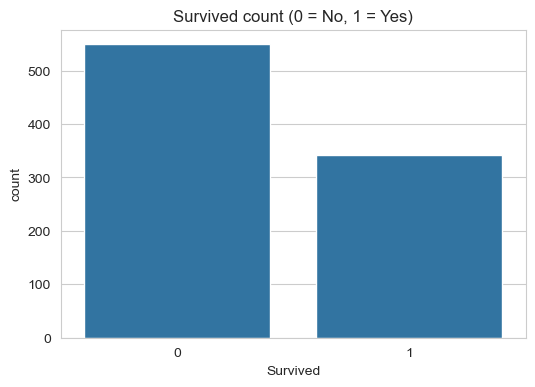

In [6]:
# Survived count
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
sns.countplot(x='Survived', data=df)
plt.title('Survived count (0 = No, 1 = Yes)')
plt.show()

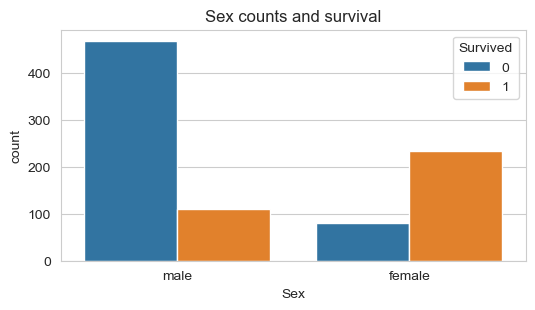

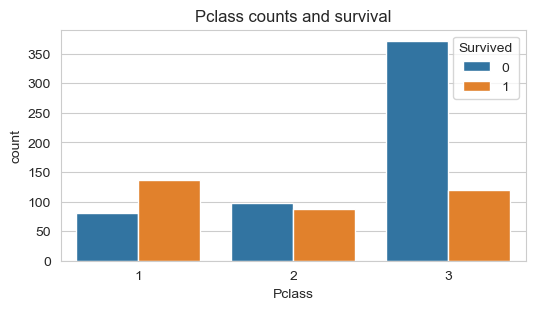

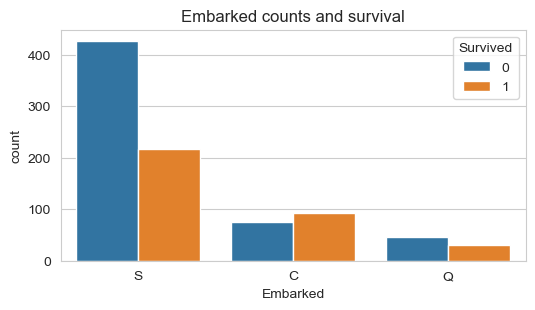

In [7]:

# Categorical features vs Survived
for col in ['Sex','Pclass','Embarked']:
    plt.figure(figsize=(6,3))
    sns.countplot(x=col, data=df, hue='Survived')
    plt.title(f'{col} counts and survival')
    plt.show()

## 6. Univariate analysis — numerical features

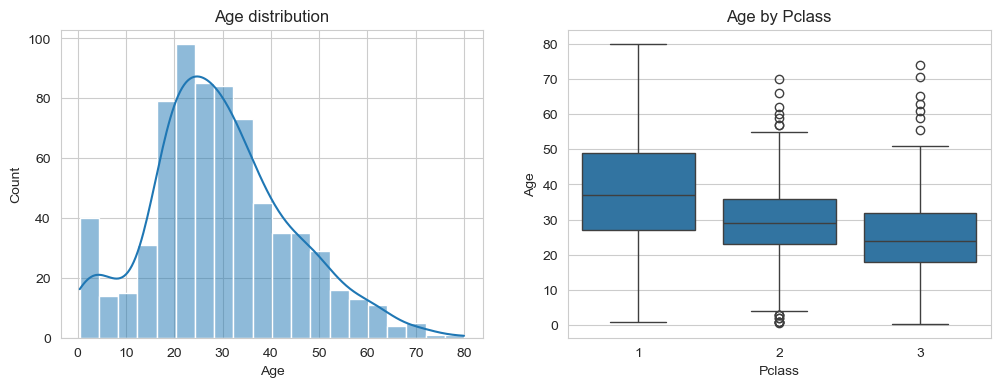

In [8]:
fig, axes = plt.subplots(1,2,figsize=(12,4))
sns.histplot(df['Age'].dropna(), ax=axes[0], kde=True)
axes[0].set_title('Age distribution')
sns.boxplot(x='Pclass', y='Age', data=df, ax=axes[1])
axes[1].set_title('Age by Pclass')
plt.show()

## 7. Bivariate analysis

Pclass         1         2         3
Sex                                 
female  0.968085  0.921053  0.500000
male    0.368852  0.157407  0.135447


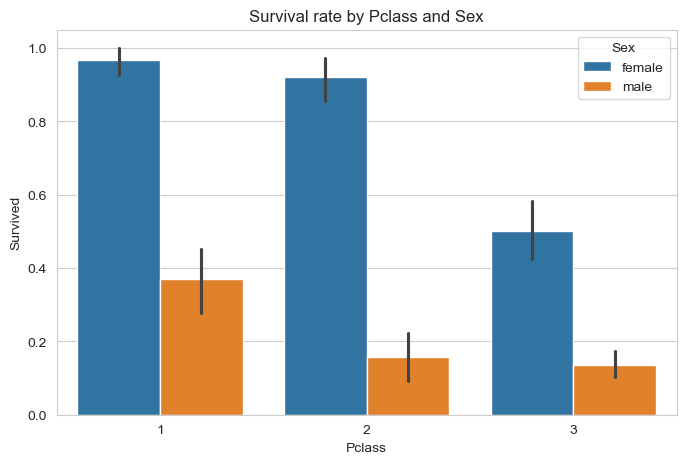

In [9]:
# Survival rate by Sex and Pclass
print(df.groupby(['Sex','Pclass'])['Survived'].mean().unstack())
plt.figure(figsize=(8,5))
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=df)
plt.title('Survival rate by Pclass and Sex')
plt.show()

## 8. Feature engineering

In [10]:
# Feature engineering
df['Title'] = df['Name'].str.extract(r'([A-Za-z]+)\.', expand=False)
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].replace(rare_titles, 'Rare')

df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
df['HasCabin'] = df['Cabin'].notnull().astype(int)

df['FareBin'] = pd.qcut(df['Fare'].fillna(0), 4, labels=False)
df['AgeBin'] = pd.cut(df['Age'].fillna(-1), bins=[-1,12,20,40,60,100], labels=['Unknown','Child','Young','Adult','Senior'])

df[['Title','FamilySize','IsAlone','HasCabin','FareBin','AgeBin']].head()

,Title,FamilySize,IsAlone,HasCabin,FareBin,AgeBin
0,Mr,2,0,0,0,Young
1,Mrs,2,0,1,3,Young
2,Miss,1,1,0,1,Young
3,Mrs,2,0,1,3,Young
4,Mr,1,1,0,1,Young


## 9. Imputation strategy

In [11]:

# Impute Age using median grouped by Title
age_map = df.groupby('Title')['Age'].median()
df['Age'] = df['Age'].fillna(df['Title'].map(age_map))
df['Age'] = df['Age'].fillna(df['Age'].median())

# Remaining nulls
df.isnull().sum().loc[lambda x: x>0]

Cabin       687
Embarked      2
AgeBin      177
dtype: int64

## 10. Correlations

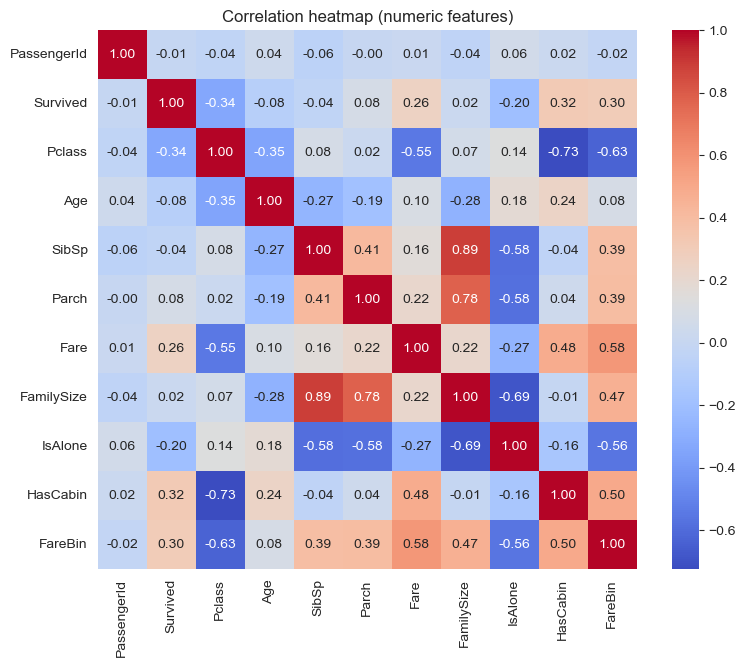

In [12]:
plt.figure(figsize=(9,7))
num_cols = df.select_dtypes(include=[np.number]).columns
sns.heatmap(df[num_cols].corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Correlation heatmap (numeric features)')
plt.show()

## simple baseline model

In [13]:

# Simple logistic regression baseline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

cols = ['Pclass','Sex','Age','Fare','FamilySize','IsAlone']
X = df.copy()
X = pd.get_dummies(X[cols], drop_first=True)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
model = LogisticRegression(max_iter=200)
model.fit(X_train, y_train)
pred = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, pred))
print(classification_report(y_test, pred))

Accuracy: 0.7988826815642458
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       105
           1       0.78      0.72      0.75        74

    accuracy                           0.80       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



## 12. Conclusions & next steps
- Females show higher survival rates than males.
- Passengers in higher classes had better survival proportions.
- Feature engineering (Title, FamilySize, HasCabin) provides useful signals.

Next steps: improved imputation, cross-validation, feature selection, tree-based models, hyperparameter tuning.